# Mission

Le projet porte sur StackOverFlow, la célèbre plateforme de questions et réponses populaire pour les développeurs. La mission est de développer un système qui génère les suggestions de tags lorsqu'un utilisateur pose une question sur le site. 
Le projet se décline sous forme de 4 notebooks:  
- un notebook avec un test du wrapper StackAPI pour récupérer 50 questions StackOverFlow     
- un notebook d'exploration et de pré-traitement des questions récupérées   
- un notebook avec une approche non supervisée de génération de tags     
- un notebook avec une approche supervisée de génération de tags  

# Génération de tags - Exploration et pré-traitement



#### [Récupération des questions de StackOverFlow avec des requêtes SQL](#recuperation)
 - [Filtre de questions avec de nombreuses vues, de nombreux commentaires, un bon score, au moins 5 tags et au moins une réponse](#filtre)
 - [Importation du fichier CSV](#importation-donnees)

#### [Analyse exploratoire](#analyse-exploratoire)
 - [Titres](#titres)
    - [Longueur des titres](#longueur-des-titres)
 - [Tags](#tags)
   - [Remplacement des balises par des virgules](#remplacement-des-balises-par-des-virgules)
   - [Décompte du nombre total de tags](#décompte-du-nombre-total-de-tags)
   - [Représentation des tags les plus fréquents](#représentation-des-tags-les-plus-fréquents)
 - [Body](#body)
   - [Suppression de l'intérieur des balises code](#suppression-de-lintérieur-des-balises-code)
   - [Remplacement du texte avec balises par du texte pur](#remplacement-du-texte-avec-balises-par-du-texte-pur)
 - [Nettoyage du code](#nettoyage-du-code)
   - [Fonctions de tokenisation et lemmatization](#fonctions-de-tokenisation-et-lemmatization)
   - [Fonction de stemmatization](#fonction-de-stemmatization)
   - [Tests des fonctions sur un texte](#tests-des-fonctions-sur-un-texte)

#### [Bag of word](#bag-of-word)
 - [Application des fonctions sur les feature body et title](#application-des-fonctions-sur-la-feature-body)
 - [Calcul de la longueur en mots des colonnes body nettoyées créées](#calcul-de-la-longueur-en-mots-des-colonnes-créées)

#### [RGPD](#rgpd)



## Récupération des questions de StackOverFlow avec des requêtes SQL

### Filtre de questions

On utilise la requête SQL suivante sur le site https://data.stackexchange.com/stackoverflow/query/new

SELECT TOP 50000  
P.Id AS PostId,  
P.Title,  
P.Body,  
P.Tags,  
P.ViewCount,  
P.CommentCount,  
P.AnswerCount,  
P.Score  
FROM Posts P  
WHERE (P.PostTypeId = 1) -- Questions  
AND (P.ViewCount IS NOT NULL) -- Nombreuses vues  
AND (P.CommentCount > 5) -- Nombreux commentaires  
AND (P.Score > 5) -- Bon score  
AND (P.AnswerCount > 0) -- Au moins une réponse  
AND (LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5) -- Au moins 5 tags  
ORDER BY P.ViewCount DESC;  

### Dépendances utilisées

ipykernel==6.26.0  
pandas==2.1.3    
matplotlib==3.8.2  
seaborn==0.13.0  
wordcloud==1.9.2  
beautifulsoup4==4.12.2  
nltk==3.8.1  

### Importation du fichier CSV

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

questions = pd.read_csv("datasets/questions_stackoverflow.csv")
questions.shape

(30582, 8)

In [3]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30582 entries, 0 to 30581
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PostId        30582 non-null  int64 
 1   Title         30582 non-null  object
 2   Body          30582 non-null  object
 3   Tags          30582 non-null  object
 4   ViewCount     30582 non-null  int64 
 5   CommentCount  30582 non-null  int64 
 6   AnswerCount   30582 non-null  int64 
 7   Score         30582 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.9+ MB


In [4]:
questions.sample(5)

,PostId,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score
27202,24816326,How do functional languages represent algebrai...,<p>If you were writing a bioinformatics algori...,<haskell><memory><functional-programming><sml>...,916,6,1,18
1097,5444394,How to implement a binary search tree in Python?,<p>This is what I've got so far but it is not ...,<python><oop><class><data-structures><binary-s...,132846,7,18,51
17289,18935242,What is the opposite of javascript window.stop(),<p>Once I've executed <code>window.stop()</cod...,<javascript><jquery><function><browser><methods>,4255,7,1,6
9133,30115866,How to properly check if all form elements are...,<p>I have a form:</p>\n\n<pre><code>&lt;form a...,<javascript><php><jquery><html><forms>,12849,12,5,13
12083,45992243,pip install pygame - SDL.h file not found,<p>MacOS Sierra</p>\n\n<pre><code>➜ fun_pytho...,<python><pygame><pip><sdl><file-not-found>,8481,6,2,9


## Analyse exploratoire

### Titres

#### Longueur des titres

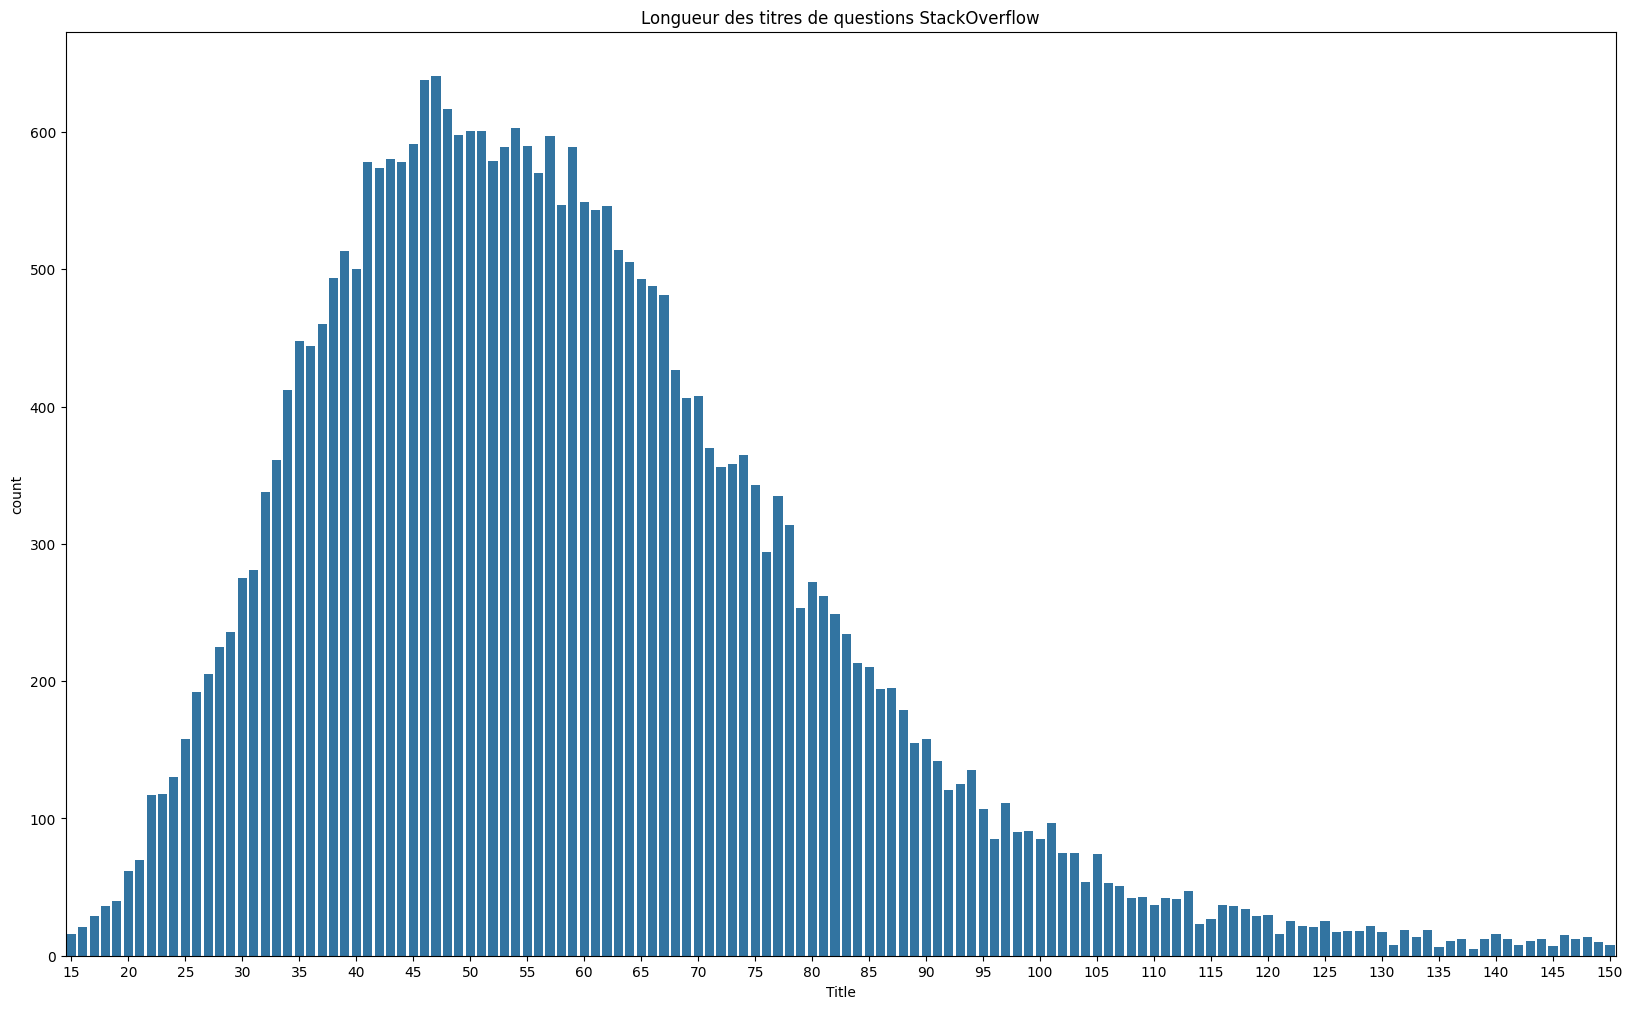

In [5]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=questions.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.title("Longueur des titres de questions StackOverflow")
plt.show()

### Tags

#### Remplacement des balises par des virgules

In [6]:
questions['Tags'] = questions['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))

# suppression de la dernière virgule
questions['Tags'] = questions['Tags'].str[:-1]

In [7]:
questions['Tags'].sample(5)

24469    javascript,html,css,twitter-bootstrap,bootstrap-4
28439        c#,performance,reflection,.net-3.5,properties
15434    tensorflow,deep-learning,pytorch,distributed-c...
27151    python,windows,multithreading,keyboard,python-...
3960                  python,string,unicode,python-3.x,int
Name: Tags, dtype: object

#### Décompte du nombre total de tags

In [8]:
def split_tags(df, column, separator):
    """
    Compte et classe les tags présents dans une colonne d'un DataFrame pandas.

    Cette fonction divise les entrées d'une colonne spécifiée d'un DataFrame selon un séparateur donné.
    Ensuite, elle compte la fréquence de chaque tag unique et retourne un DataFrame avec ces compteurs.

    Paramètres:
    df (pandas.DataFrame): Le DataFrame à partir duquel les tags doivent être comptés.
    column (str): Le nom de la colonne dans le DataFrame où les tags sont stockés.
    separator (str): Le caractère ou la chaîne de caractères utilisé(e) pour séparer les tags dans la colonne.

    Retours:
    pandas.DataFrame: Un DataFrame contenant deux colonnes - 'Tag' et 'tag_count'.
                      'Tag' contient les tags uniques, et 'tag_count' contient le nombre d'occurrences de chaque tag.

    """
    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words


In [9]:
tags_list = split_tags(df=questions, column='Tags', separator=',')
print("Le dataset contient {} tags.".format(tags_list.shape[0]))

Le dataset contient 14084 tags.


#### Représentation des tags les plus fréquents

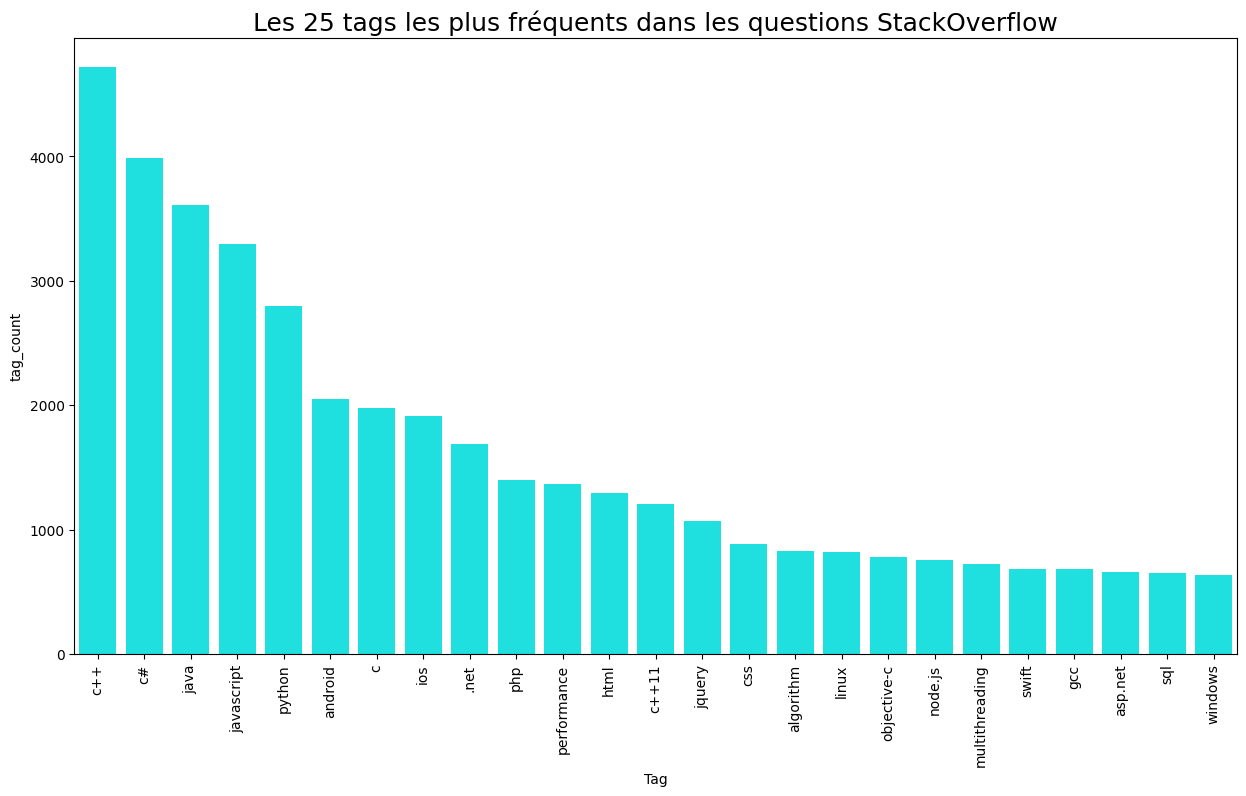

In [10]:
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:25, :],
            x=tags_list.iloc[0:25, :].index,
            y="tag_count", color="#00FFFF")
plt.xticks(rotation=90)
plt.title("Les 25 tags les plus fréquents dans les questions StackOverflow",
          fontsize=18)
plt.show()

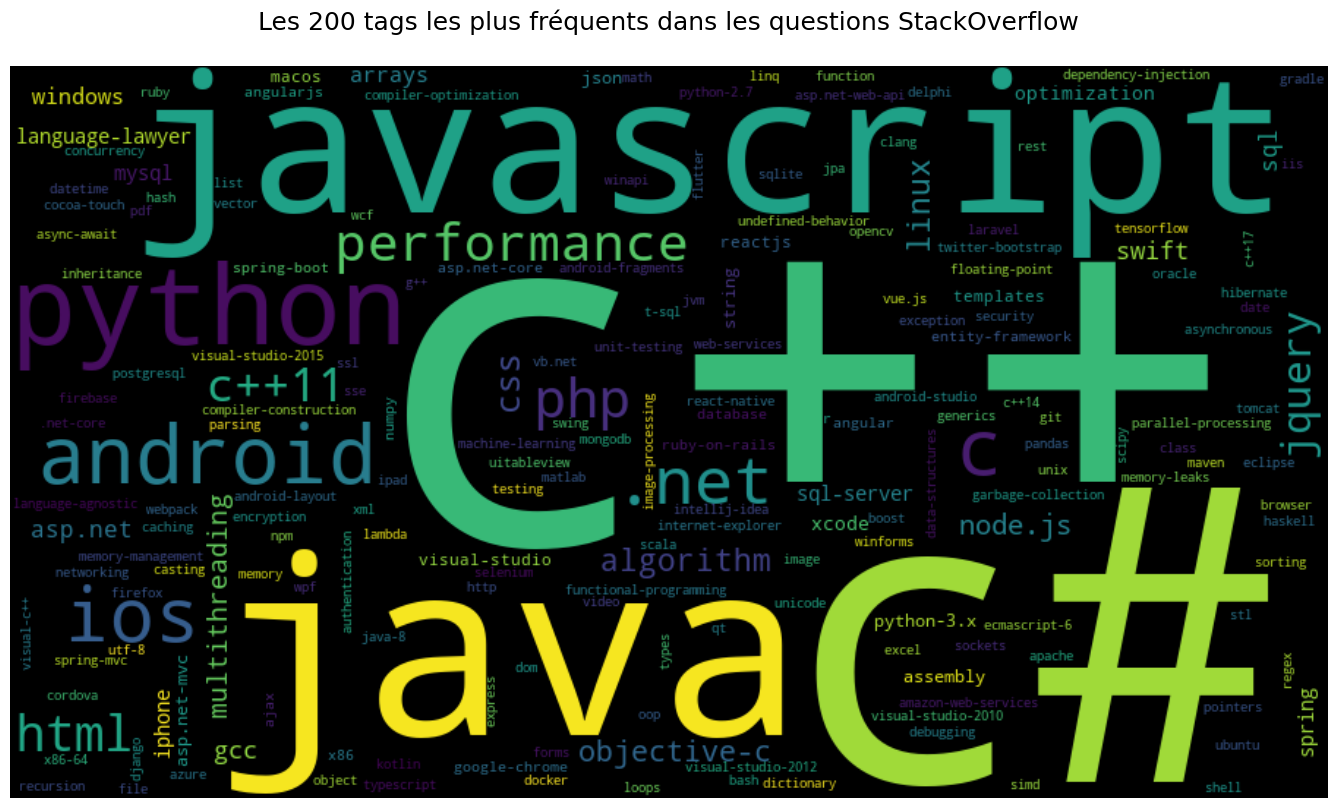

In [12]:
from wordcloud import WordCloud

fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=200, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(tags_list.to_dict()['tag_count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Les 200 tags les plus fréquents dans les questions StackOverflow\n",
          fontsize=18)
plt.show()

### Body

#### Suppression de l'intérieur des balises code

In [14]:
from bs4 import BeautifulSoup

def delete_code(x):
    soup = BeautifulSoup(x, "html.parser")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [15]:
questions['Body'] = questions['Body'].apply(delete_code)

#### Remplacement du texte avec balises par du texte pur


In [16]:
questions['Body'] = [BeautifulSoup(text, "html.parser").get_text() for text in questions['Body']]

### Nettoyage du code

Pour la conservation uniquement des noms

In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/julienbremeersch/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Fonctions de tokenisation et lemmatization

In [20]:
# Tokenizer
from nltk.tokenize import word_tokenize

def tokenizer_fct(sentence) :
    sentence_clean = sentence.replace('-', ' ').replace('/', ' ').replace("'", " ")
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Filtrage des mots basé sur le seuil de fréquence
# from collections import Counter
#     word_freq = Counter(lw)
#     lw = [word for word in lw if word_freq[word] >= freq_threshold]

#### Fonction de filtrage des mots pour ne conserver que les noms

In [21]:
def filter_nouns(list_words):
    # Étiquetage grammatical des mots
    pos_tags = nltk.pos_tag(list_words)
    # Filtrage pour ne conserver que les noms
    # NN : nom, singulier ou massif
    # NNS : nom, pluriel
    # NNP : nom propre, singulier
    # NNPS : nom propre, pluriel
    nouns = [word for word, pos in pos_tags if pos in ('NN', 'NNS', 'NNP', 'NNPS')]
    return nouns

#### Fonctions de préparation du texte pour les bag of words

In [22]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_stopwords_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization et filtrage de noms
def transform_bow(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    nn_w = filter_nouns(lem_w)    
    transf_desc_text = ' '.join(nn_w)
    return transf_desc_text

#### Fonction de préparation du texte pour les embeddings (USE et BERT)

In [23]:
def transform_emb_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

#### Fonction de stemmatization

In [24]:
from nltk.stem import SnowballStemmer

language = 'english'
stemmer = SnowballStemmer(language)

def stem_fct(list_words) :
    stemmed_words = [stemmer.stem(word) for word in list_words]
    return stemmed_words


def transform_bow_stem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = stem_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

#### Tests des fonctions sur un texte

In [25]:
corpus = "These are some words about natural language processing, nltk belongs to popular Python libraries which are absolutely great for text analysis, they are used by many data specialists. Many data specialists. Many specialists, data laguage specialist"

tokenized_text = tokenizer_fct(corpus)
tokenized_and_stopword_text = transform_bow_stopwords_fct(corpus)
stemmed_text = transform_bow_stem_fct(corpus)
lemmatized_text = transform_bow_lem_fct(corpus)
bow_text = transform_bow(corpus)

print("Tokenized Text: ", tokenized_text)
print("Tokenized Text and no stopwords: ", tokenized_and_stopword_text)
print("Stemmed Text: ", stemmed_text)
print("Lemmatized Text: ", lemmatized_text)
print("Filtered nouns text: ", bow_text)


Tokenized Text:  ['These', 'are', 'some', 'words', 'about', 'natural', 'language', 'processing', ',', 'nltk', 'belongs', 'to', 'popular', 'Python', 'libraries', 'which', 'are', 'absolutely', 'great', 'for', 'text', 'analysis', ',', 'they', 'are', 'used', 'by', 'many', 'data', 'specialists', '.', 'Many', 'data', 'specialists', '.', 'Many', 'specialists', ',', 'data', 'laguage', 'specialist']
Tokenized Text and no stopwords:  these words natural language processing nltk belongs popular python libraries absolutely great text analysis used many data specialists many data specialists many specialists data laguage specialist
Stemmed Text:  these word natur languag process nltk belong popular python librari absolut great text analysi use mani data specialist mani data specialist mani specialist data laguag specialist
Lemmatized Text:  these word natural language processing nltk belongs popular python library absolutely great text analysis used many data specialist many data specialist many sp

## Bag of word

### Application des fonctions sur les feature Body et Title

In [26]:
questions['Body_bow'] = questions['Body'].apply(lambda x : transform_bow(x))
questions['Body_emb'] = questions['Body'].apply(lambda x : transform_emb_fct(x))

In [27]:
questions['Title_bow'] = questions['Title'].apply(lambda x : transform_bow(x))
questions['Title_emb'] = questions['Title'].apply(lambda x : transform_emb_fct(x))

### Calcul de la longueur en mots des colonnes créées

In [28]:
questions['Question_bow'] = questions['Title_bow'].astype(str) + ' ' + questions['Body_bow'].astype(str)

In [29]:
questions['length_bow'] = questions['Question_bow'].apply(lambda x : len(word_tokenize(x)))
print("Taille maximale de la question (bow): ", questions['length_bow'].max())

Taille maximale de la question (bow):  1118


In [30]:
questions.sample(5)

,PostId,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,Body_bow,Body_emb,Title_bow,Title_emb,Question_bow,length_bow
29564,21001424,Creating resizable website with lack of CSS sk...,"This is my first question here, so please poin...","javascript,html,css,svg,css-shapes",392,11,2,6,question please point mistake create page look...,"this is my first question here , so please poi...",lack cs skill shape,creating resizable website with lack of css sk...,lack cs skill shape question please point mist...,49
7045,17665080,overflow-x: hidden is breaking jquery scroll e...,I am having an issue where setting overflow-x:...,"jquery,html,css,scroll,overflow",18153,6,6,22,issue html body jquery scroll event jsfiddle.n...,i am having an issue where setting overflow x ...,hidden jquery scroll event,overflow x : hidden is breaking jquery scroll ...,hidden jquery scroll event issue html body jqu...,29
2486,9936132,Why does the order of the loops affect perform...,Below are two programs that are almost identic...,"c,performance,for-loop,optimization,cpu-cache",58770,14,7,409,program amount time someone version version,below are two programs that are almost identic...,order loop performance iterating array,why does the order of the loops affect perform...,order loop performance iterating array program...,11
26704,37708381,Failure to bind socket when custom ip is set f...,The problem\nOn our system running RTEMS 4.9.2...,"c++,c,sockets,networking,rtems",1026,15,1,6,problem system issue socket communication sock...,the problem on our system running rtems 4.9.2 ...,failure bind socket custom ethernet adapter,failure to bind socket when custom ip is set f...,failure bind socket custom ethernet adapter pr...,88
2395,41934528,Add a new column with a value to the select qu...,I would like to know how to create a default v...,"php,mysql,laravel,select,eloquent",60864,8,6,23,create default type set value car join laravel...,i would like to know how to create a default v...,column value query laravel,add a new column with a value to the select qu...,column value query laravel create default type...,31


In [31]:
questions.shape

(30582, 14)

In [32]:
questions['Tags_list'] = questions['Tags'].str.split(',')
questions['Question_bow'] = questions['Question_bow'].str.replace(' ', ', ')
questions['Question_list'] = questions['Question_bow'].str.split(',')

In [33]:
questions.to_csv("datasets/questions_cleaned_stackoverflow.csv")

## RGPD

Les données utilisées ici respectent les 5 grands principes RGPD:  

Principe de transparence : Les données sont traitées légalement.  

Principe de respect des données personnelles : aucune information ne permet d’identifier les personnes qui sont les auteurs des questions.

Principe de minimisation des données : Seules les données nécessaires à la réalisation des objectifs spécifiques sont utilisées: ici les questions, les tags, les scores pour la pertinence des questions.

Principe d'exactitude : Les données doivent être exactes et, si nécessaire, mises à jour. Cela garantit que les informations inexactes sont corrigées ou supprimées rapidement.

Principe de limitation de la conservation : Les données ne doivent pas être conservées plus longtemps que nécessaire par rapport aux finalités pour lesquelles elles ont été traitées. 